In [39]:
import argparse
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.utils.data
import torchmetrics as tm
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from icecream import ic
from PIL import Image
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
)
from sklearn.svm import LinearSVC
from torch.autograd import Variable
from tqdm import tqdm

# Partie 1 : Architecture VGG16


## 3. Apply the network on several images of your choice


From the [PyTorch documentation](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html), the VGG input has to be `(C, H, W)` :

> The inference transforms are available at VGG16_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].


In [2]:
torchvision.models.VGG16_Weights.IMAGENET1K_V1.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


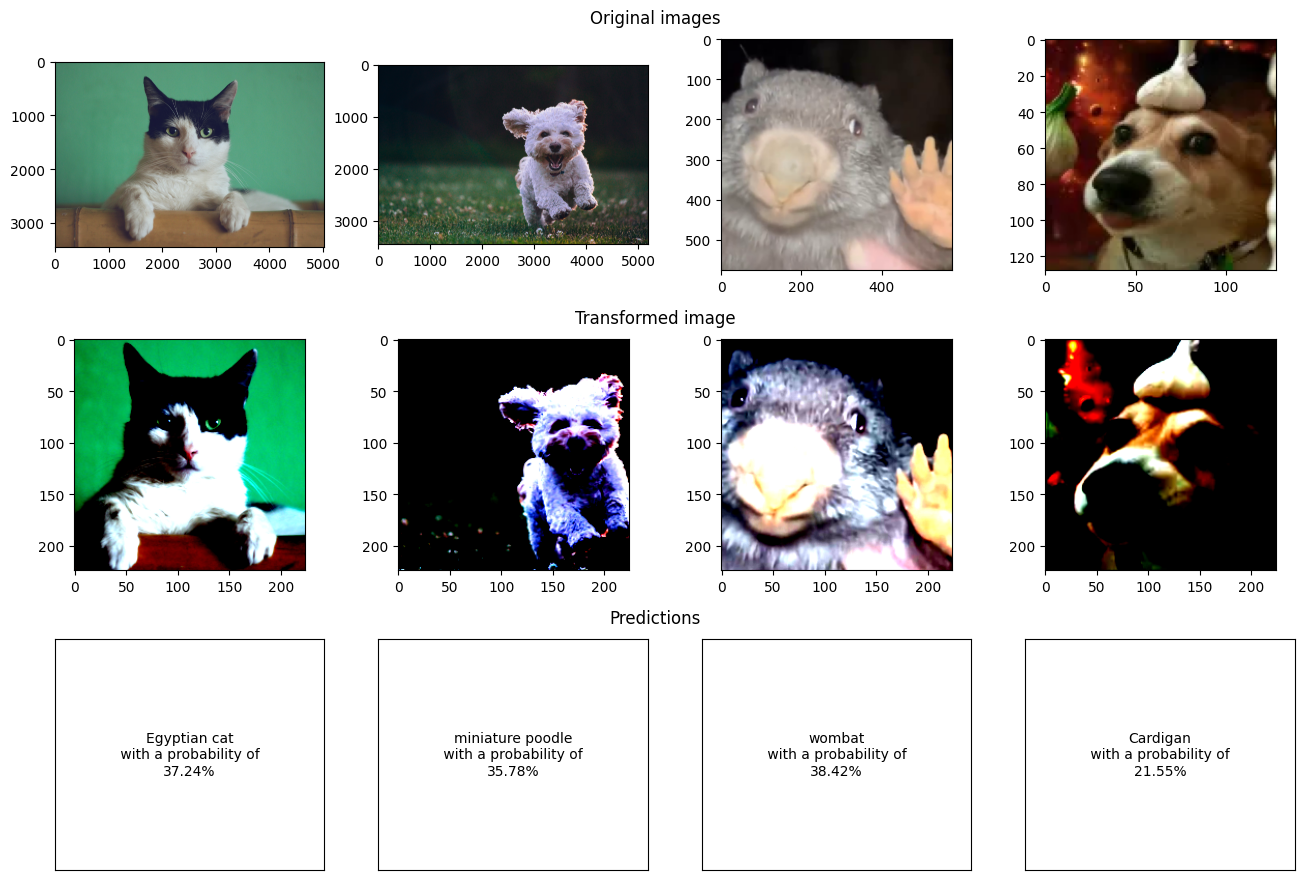

In [3]:
dog_meme = Image.open("kadaver-vanilla.webp")
bobr = Image.open("bobr.png").convert("RGB")  # 4 channels here
dog = Image.open("dog.jpg")
cat = Image.open("cat.jpg")

vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)
vgg16.eval()
imagenet_classes = pickle.load(
    open("imagenet_classes.pkl", "rb")
)  # chargement du nom des classes


def print_min_max(img):
    img2 = np.array(img)
    print("Min: %.3f, Max: %.3f" % (img2.min(), img2.max()))
    print(img2.shape)
    return img


def manual_norm(img):
    m = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return (img - m) / std


model_transform_pipeline = torchvision.models.VGG16_Weights.IMAGENET1K_V1.transforms()
to_view_transform_pipeline = transforms.Compose(
    [
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.Resize((256, 256), interpolation=Image.BILINEAR),
        transforms.CenterCrop(224),
        transforms.Lambda(lambda img: np.array(img) / 255.0),
    ]
)
# we reproduce the model transformation for plotting

fig = plt.figure(figsize=(16, 9))
# fig.suptitle('')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
axs = subfigs[0].subplots(nrows=1, ncols=4)
subfigs[0].suptitle("Original images")
for ax, img in zip(axs, [cat, dog, bobr, dog_meme]):
    ax.imshow(img)

axs = subfigs[1].subplots(nrows=1, ncols=4)
subfigs[1].suptitle("Transformed image")
for ax, img in zip(axs, [cat, dog, bobr, dog_meme]):
    x = model_transform_pipeline(img).permute(1, 2, 0)
    ax.imshow(x)

axs = subfigs[2].subplots(nrows=1, ncols=4)
subfigs[2].suptitle("Predictions")
for ax, img in zip(axs, [cat, dog, bobr, dog_meme]):
    x = model_transform_pipeline(img).unsqueeze(0)  # to batch
    y_hat = vgg16(x).squeeze()
    y_hat = torch.nn.functional.softmax(y_hat, dim=0)
    idx = y_hat.argmax()
    txt = (
        imagenet_classes[idx.item()].split(",")[0]
        + f"\n with a probability of \n{y_hat.max().item():.02%}"
    )  # if multiple classes
    ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis="y", which="both", right=False, left=False, labelleft=False)
    ax.text(0.5, 0.5, txt, horizontalalignment="center", verticalalignment="center")
# fig.savefig("predictions.pdf", dpi=300, bbox_inches="tight")

In [4]:
dog_meme = Image.open("kadaver-vanilla.webp")
bobr = Image.open("bobr.png")
dog = Image.open("dog.jpg")
cat = Image.open("cat.jpg")
komondor = Image.open("komondor.jpg")
komondor_mop = Image.open("sheepdog_mop.jpg")

images = {
    "cat": cat,
    "dog": dog,
    "wombat": bobr.convert("RGB"),  # conversion because 4 channels
    "dog (meme)": dog_meme,
    "komondor": komondor,
    "komondor or mop?": komondor_mop,
}

# VGG16 model and class names
vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)
vgg16.eval()
imagenet_classes = pickle.load(open("imagenet_classes.pkl", "rb"))

# Transformation pipelines
model_transform_pipeline = torchvision.models.VGG16_Weights.IMAGENET1K_V1.transforms()
to_view_transform_pipeline = transforms.Compose(
    [
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.Resize((226, 226), interpolation=Image.BILINEAR),
        transforms.CenterCrop(224),
        transforms.Lambda(lambda img: np.array(img) / 255.0),
    ]
)


def get_top_predictions(img, top_k=5):
    """Get the top 5 predictions from VGG16 given an image."""
    x = model_transform_pipeline(img).unsqueeze(0)
    y_hat = vgg16(x).squeeze()
    y_hat = torch.nn.functional.softmax(y_hat, dim=0)
    top_values, top_indices = torch.topk(y_hat, top_k)
    top_predictions = [imagenet_classes[idx.item()] for idx in top_indices]
    return top_predictions, top_values.detach().numpy()


def save_original_images(images, filename="original_images.pdf"):
    """Function to save original images."""
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
    for ax, (file, img) in zip(axs, images.items()):
        ax.imshow(img)
        ax.set_title(file, fontsize=14)
        ax.axis("off")
    fig.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches="tight")


def save_transformed_images(images, filename="transformed_images.pdf"):
    """Function to save transformed images."""
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
    for ax, (file, img) in zip(axs, images.items()):
        img = model_transform_pipeline(img).permute(1, 2, 0)
        ax.imshow(img)
        ax.set_title("Transformed " + file, fontsize=14)
        ax.axis("off")
    fig.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches="tight")


def save_prediction_plots(images, filename="prediction_plots.pdf"):
    """Function to save bar plots of predictions."""
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
    for ax, (file, img) in zip(axs, images.items()):
        predictions, values = get_top_predictions(img)
        predictions, values = zip(
            *sorted(zip(predictions, values), key=lambda x: x[1], reverse=True)
        )
        bar_colors = [
            "#f28e2b" if j == 0 else "#4e79a7" for j in range(len(predictions))
        ]
        bar_labels = [f"{val * 100:.2f}%" for val in values]

        bars = ax.bar(predictions, values, color=bar_colors)
        ax.bar_label(bars, labels=bar_labels, padding=4, fontsize=8, label_type="edge")
        ax.set_xticks(
            range(len(predictions)),
            labels=[pred.split(",")[0] for pred in predictions],
            rotation=45,
        )
        ax.set_yticks([])
        ax.set_title("Top 5 predictions for " + file)
        ax.set_ylim(0, max(values) * 1.1)
    fig.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches="tight")


# save_original_images(images)
# save_transformed_images(images)
# save_prediction_plots(images)

## 4. Activation maps' visualisation


First convolutional layer = first block (two layers) or first layer?? For me, first layer.

In [82]:
import matplotlib.cm as cm


def plot_activation_maps(img):
    activation = {}
    cmap = cm.viridis

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()

        return hook

    hook = vgg16.features[1].register_forward_hook(get_activation("conv1")) 
    x = model_transform_pipeline(img).unsqueeze(0)
    vgg16.eval()
    vgg16(x)

    hook.remove()

    activation_maps = activation["conv1"].squeeze(0)

    # Normalize the activation maps and apply colormap
    colored_maps = []
    for activation_map in activation_maps:
        colored_map = cmap(activation_map.cpu().numpy())[:, :, :3]  # RGB channels
        colored_maps.append(
            torch.from_numpy(colored_map).permute(2, 0, 1)
        )  # Convert to (C, H, W)

    # Create a tensor of all colored maps
    colored_maps_tensor = torch.stack(colored_maps)

    # Make a grid of the activation maps
    grid = torchvision.utils.make_grid(
        colored_maps_tensor, nrow=8, padding=1, normalize=False
    )

    # Convert grid to a PIL image for display
    grid = torchvision.transforms.functional.to_pil_image(grid)

    # Display the grid
    fig = plt.figure(figsize=(12, 12))
    plt.imshow(np.asarray(grid))
    plt.axis("off")
    return fig

In [ ]:
for file, img in images.items():
    plot_activation_maps(img)
    # plt.savefig(f"activation_{file}.pdf", dpi=300, bbox_inches="tight")
    plt.show()

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene


## Feature extraction with VGG16


In [7]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
def get_dataset(batch_size, path, transform=None):
    def duplicateChannel(img):
        img = img.convert("RGB")
        # np_img = np.array(img, dtype=np.uint8)
        # np_img = np.dstack([np_img, np_img, np_img])
        # img = Image.fromarray(np_img, 'RGB')
        return img

    # Cette fonction permet de recopier 3 fois une image qui ne serait que sur 1 channel
    # (donc image niveau de gris) pour la "transformer" en image RGB.
    # Utilisez la avec transform.Lambda
    if not transform:
        transform = (
            transforms.Compose(
                [  # Pré-traitement à faire
                    transforms.Resize((224, 224), interpolation=Image.BILINEAR),
                    transforms.Lambda(duplicateChannel),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]
            ),
        )

    train_dataset = datasets.ImageFolder(path + "/train", transform=transform)
    val_dataset = datasets.ImageFolder(path + "/test", transform=transform)

    CUDA = torch.cuda.is_available()
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=CUDA,
        num_workers=2,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=CUDA,
        num_workers=2,
    )

    return train_loader, val_loader


class VGG16relu7(nn.Module):
    def __init__(self, vgg16):
        super().__init__()
        self.features = vgg16.features
        # self.avgpool = vgg16.avgpool
        self.classifier = vgg16.classifier[:-2]

    def forward(self, x):
        # ic(x.size())
        x = self.features(x)
        # x = self.avgpool(x)
        # ic(x.size())
        x = x.view(x.size(0), -1)
        # ic(x.size())
        x = self.classifier(x)
        return x

In [34]:
def extract_features(data, model, device, desc):
    X = torch.tensor([], device=device)
    y = torch.tensor([])

    for input, target in tqdm(data, total=len(data), unit="batch", desc=desc):
        input = input.to(device)
        X = torch.cat((X, model(input)))
        y = torch.cat((y, target))
    return X, y


def extract_from_model(model, path="15SceneData", batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Instanciation de VGG16...")
    w = torchvision.models.VGG16_Weights.IMAGENET1K_V1
    model_transform_pipeline = w.transforms()
    vgg16 = torchvision.models.vgg16(weights=w)

    print(f"Instanciation de {model.__name__}...")
    model = model(vgg16)
    model.eval()
    model.to(device)

    # On récupère les données
    print("Récupération des données...")
    train, test = get_dataset(batch_size, path, transform=model_transform_pipeline)

    # Extraction des features
    print("Feature extraction...")
    with torch.no_grad():
        X_train, y_train = extract_features(
            train, model, device=device, desc="Extracting train..."
        )
        X_test, y_test = extract_features(
            test, model, device=device, desc="Extracting test..."
        )
    return X_train.cpu(), X_test.cpu(), y_train.cpu(), y_test.cpu()

## Training SVM classifiers


In [48]:
from sklearn.metrics import ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = extract_from_model(VGG16relu7)

# Apprentissage et évaluation des SVM à faire
print("Apprentissage du SVM sans normalization")
svm = LinearSVC(C=1.0, dual="auto", max_iter=1000).fit(X_train, y_train)
y_hat = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_hat)
cm_score = confusion_matrix(y_test, y_hat)
print("Accuracy = %f" % accuracy)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_score, display_labels=svm.classes_)
# disp.plot()
# plt.show()

print("Apprentissage du SVM avec normalization")
X_train_normalized = nn.functional.normalize(X_train, p=2, dim=1)
X_test_normalized = nn.functional.normalize(X_test, p=2, dim=1)
svm = LinearSVC(C=1.0, dual="auto", max_iter=1000).fit(X_train_normalized, y_train)
y_hat = svm.predict(X_test_normalized)
cm_score = confusion_matrix(y_test, y_hat)
print("Accuracy = %f" % accuracy)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_score, display_labels=svm.classes_)
# disp.plot()
# plt.show()

Instanciation de VGG16...


Instanciation de VGG16relu7...
Récupération des données...
Feature extraction...


Extracting test...: 100%|██████████| 374/374 [00:07<00:00, 50.91batch/s]


Apprentissage du SVM sans normalization


/home/valinquish/DAC/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy = 0.896482
Apprentissage du SVM avec normalization
Accuracy = 0.896482


In [50]:
from sklearn.model_selection import GridSearchCV


# Set the parameters by cross-validation
param_grid = [
    {
        "C": [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
    },
]

# Create a classifier object with the SVC class
svc = LinearSVC(dual="auto", max_iter=2000)

# Create the grid search object
grid_search = GridSearchCV(svc, param_grid, n_jobs=2)

# Fit the grid search object to our data to compute the best model
grid_search.fit(X_train_normalized, y_train)

# Print out the results of grid search
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best estimator to make predictions on the test set
best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test)

# Calculate the accuracy score
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

Best parameters found: {'C': 1.75}
Best cross-validation score: 0.9093333333333333


0.8512562814070351

## Going further


### Changing layers


In [57]:
class VGG16relu6(nn.Module):
    def __init__(self, vgg16):
        super().__init__()
        self.features = vgg16.features
        self.classifier = vgg16.classifier[:-5]

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


X_train, X_test, y_train, y_test = extract_from_model(VGG16relu6)

# Apprentissage et évaluation des SVM à faire
print("Apprentissage du SVM sans normalization")
svm = LinearSVC(C=1.0, dual="auto", max_iter=1000).fit(X_train, y_train)
accuracy = accuracy_score(y_test, svm.predict(X_test))
print("Accuracy = %f" % accuracy)

print("Apprentissage du SVM avec normalization")
X_train_normalized = nn.functional.normalize(X_train, p=2, dim=1)
X_test_normalized = nn.functional.normalize(X_test, p=2, dim=1)
svm = LinearSVC(C=1.0, dual="auto", max_iter=1000).fit(X_train_normalized, y_train)
accuracy = accuracy_score(y_test, svm.predict(X_test_normalized))
print("Accuracy = %f" % accuracy)

Instanciation de VGG16...
Instanciation de VGG16relu6...
Récupération des données...
Feature extraction...


Extracting test...: 100%|██████████| 374/374 [00:07<00:00, 47.69batch/s]


Apprentissage du SVM sans normalization


/home/valinquish/DAC/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy = 0.905863
Apprentissage du SVM avec normalization
Accuracy = 0.911893


In [52]:
from sklearn.model_selection import GridSearchCV


# Set the parameters by cross-validation
param_grid = [
    {
        "C": [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
    },
]

# Create a classifier object with the SVC class
svc = LinearSVC(dual="auto", max_iter=2000)

# Create the grid search object
grid_search = GridSearchCV(svc, param_grid, n_jobs=2)

# Fit the grid search object to our data to compute the best model
grid_search.fit(X_train_normalized, y_train)

# Print out the results of grid search
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best estimator to make predictions on the test set
best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test)

# Calculate the accuracy score
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

Best parameters found: {'C': 1}
Best cross-validation score: 0.9173333333333333


0.8656616415410385

In [59]:
class VGG16relu8(nn.Module):
    def __init__(self, vgg16):
        super().__init__()
        self.features = vgg16.features
        self.classifier = vgg16.classifier

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


X_train, X_test, y_train, y_test = extract_from_model(VGG16relu8)

# Apprentissage et évaluation des SVM à faire
print("Apprentissage du SVM sans normalization")
svm = LinearSVC(C=1.0, dual="auto", max_iter=1000).fit(X_train, y_train)
accuracy = accuracy_score(y_test, svm.predict(X_test))
print("Accuracy = %f" % accuracy)

print("Apprentissage du SVM avec normalization")
X_train_normalized = nn.functional.normalize(X_train, p=2, dim=1)
X_test_normalized = nn.functional.normalize(X_test, p=2, dim=1)
svm = LinearSVC(C=1.0, dual="auto", max_iter=1000).fit(X_train_normalized, y_train)
accuracy = accuracy_score(y_test, svm.predict(X_test_normalized))
print("Accuracy = %f" % accuracy)

Instanciation de VGG16...


Instanciation de VGG16relu8...
Récupération des données...
Feature extraction...


Extracting test...: 100%|██████████| 374/374 [00:08<00:00, 44.75batch/s]


Apprentissage du SVM sans normalization
Accuracy = 0.861307
Apprentissage du SVM avec normalization
Accuracy = 0.880067


In [60]:
from sklearn.model_selection import GridSearchCV


# Set the parameters by cross-validation
param_grid = [
    {
        "C": [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
    },
]

# Create a classifier object with the SVC class
svc = LinearSVC(dual="auto", max_iter=1000)

# Create the grid search object
grid_search = GridSearchCV(svc, param_grid, n_jobs=2)

# Fit the grid search object to our data to compute the best model
X = np.concatenate((X_train_normalized, X_test_normalized))
y = np.concatenate((y_train, y_test))
grid_search.fit(X, y)

# Print out the results of grid search
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best estimator to make predictions on the test set
best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test)

# Calculate the accuracy score
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

Best parameters found: {'C': 2}
Best cross-validation score: 0.902118171683389


0.7078726968174205

In [29]:
class VGG16relu8(nn.Module):
    def __init__(self, vgg16):
        super().__init__()
        self.features = vgg16.features
        self.avgpool = vgg16.avgpool  # n'a aucune importance
        self.classifier = vgg16.classifier

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


X_train, X_test, y_train, y_test = extract_from_model(VGG16relu8)

# Apprentissage et évaluation des SVM à faire
print("Apprentissage du SVM sans normalization")
svm = LinearSVC(C=1.0, dual="auto", max_iter=1000).fit(X_train, y_train)
accuracy = accuracy_score(y_test, svm.predict(X_test))
print("Accuracy = %f" % accuracy)

print("Apprentissage du SVM avec normalization")
X_train_normalized = nn.functional.normalize(X_train, p=2, dim=1)
X_test_normalized = nn.functional.normalize(X_test, p=2, dim=1)
svm = LinearSVC(C=1.0, dual="auto", max_iter=1000).fit(X_train_normalized, y_train)
accuracy = accuracy_score(y_test, svm.predict(X_test_normalized))
print("Accuracy = %f" % accuracy)

Instanciation de VGG16...
Instanciation de VGG16relu8...
Récupération des données...
Feature extraction...


Extracting test...: 100%|██████████| 374/374 [00:07<00:00, 48.34batch/s]


Apprentissage du SVM sans normalization
Accuracy = 0.860972
Apprentissage du SVM avec normalization
Accuracy = 0.880067


### SVM tunning


In [12]:
from sklearn.model_selection import GridSearchCV


# Set the parameters by cross-validation
param_grid = [
    {
        "C": [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
        "dual": ["auto"],
        "max_iter": [2000],
    },
]

# Create a classifier object with the SVC class
svc = LinearSVC()

# Create the grid search object
grid_search = GridSearchCV(svc, param_grid, n_jobs=-1)

# Fit the grid search object to our data to compute the best model
grid_search.fit(X_train_normalized, y_train)

# Print out the results of grid search
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best estimator to make predictions on the test set
best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test)

# Calculate the accuracy score
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

: 

In [14]:
# for c in [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2] + list(range(2, 15)):
#     svm = LinearSVC(C=c, dual="auto", max_iter=2000).fit(X_train_normalized, y_train)
#     accuracy = accuracy_score(y_test, svm.predict(X_test_normalized))
#     print(f"Accuracy for {c}= {accuracy}")

Accuracy for 0.25= 0.8921273031825796
Accuracy for 0.5= 0.8968174204355109
Accuracy for 0.75= 0.9005025125628141
Accuracy for 1= 0.9008375209380235
Accuracy for 1.25= 0.8998324958123953
Accuracy for 1.5= 0.8991624790619765
Accuracy for 1.75= 0.8994974874371859
Accuracy for 2= 0.8994974874371859
Accuracy for 2= 0.8994974874371859
Accuracy for 3= 0.8984924623115578
Accuracy for 4= 0.8984924623115578
Accuracy for 5= 0.8991624790619765
Accuracy for 6= 0.8991624790619765
Accuracy for 7= 0.8988274706867672
Accuracy for 8= 0.8991624790619765
Accuracy for 9= 0.8984924623115578
Accuracy for 10= 0.8981574539363484
Accuracy for 11= 0.8974874371859296
Accuracy for 12= 0.8968174204355109
Accuracy for 13= 0.8964824120603015
Accuracy for 14= 0.8961474036850922


### Using a NN as output classifier


#### Independantly of VGG


In [58]:
def run_epoch(
    loader, model, loss_fn, optimizer=None, logger=None, device="cuda", num_classes=18
):
    loss_list = []
    acc = tm.classification.Accuracy(task="multiclass", num_classes=num_classes)
    acc.to(device)
    model.to(device)
    model.train() if optimizer else model.eval()
    for input, target in loader:
        input = input.to(device)
        target = target.to(device)

        # ic(input.size())
        # ic(target.size())
        output = model(input)
        # ic(output)
        # ic(target)
        loss = loss_fn(output, target)
        loss_list.append(loss.item())
        acc(output.argmax(1), target)
        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return np.array(loss_list).mean(), acc.compute().item()


class MLP(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 15)
        self.droput = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.droput(x)
        x = F.relu(self.fc2(x))
        x = self.droput(x)
        x = self.fc3(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 0.001
nb_epoch = 10


train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_normalized, y_train.type(torch.LongTensor)),
    batch_size=8,
    shuffle=True,
    num_workers=2,
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_test_normalized, y_test.type(torch.LongTensor)),
    batch_size=8,
    shuffle=False,
    num_workers=2,
)
model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

pbar = tqdm(range(nb_epoch))
for epoch in pbar:
    mean_train_loss, acc_train = run_epoch(
        train_loader, model, loss_fn, optimizer, device=device, num_classes=15
    )
    mean_test_loss, acc_test = run_epoch(
        test_loader, model, loss_fn, device=device, num_classes=15
    )
    pbar.set_description(
        f"Train Loss = {mean_train_loss}, Train Acc = {acc_train}, Test Loss = {mean_test_loss}, Test Acc = {acc_test}"
    )

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss = 0.0020507676867867865, Train Acc = 1.0, Test Loss = 0.40781569808668583, Test Acc = 0.9018425345420837: 100%|██████████| 10/10 [00:23<00:00,  2.34s/it]             


On obtient les même performances que partout


#### With of VGG


In [15]:
class VGG16_custom_classifier(nn.Module):
    def __init__(self, vgg16):
        super().__init__()
        self.features = vgg16.features[:-1]
        self.avgpool = vgg16.avgpool
        self.classifier = MLP(dropout_rate=0.8)

    def forward(self, x):
        # ic(x.size())
        x = self.features(x)
        x = self.avgpool(x)
        # ic(x.size())
        x = x.view(x.size(0), -1)
        # ic(x.size())
        x = self.classifier(x)
        return x


vgg16_custom_classifier = VGG16_custom_classifier(vgg16)
pbar = tqdm(range(nb_epoch))
for epoch in pbar:
    mean_train_loss, acc_train = run_epoch(
        train_loader, model, loss_fn, optimizer, device=device, num_classes=15
    )
    mean_test_loss, acc_test = run_epoch(
        test_loader, model, loss_fn, device=device, num_classes=15
    )
    pbar.set_description(
        f"Train Loss = {mean_train_loss}, Train Acc = {acc_train}, Test Loss = {mean_test_loss}, Test Acc = {acc_test}"
    )

  0%|          | 0/10 [00:00<?, ?it/s]

ic| mean_train_loss: 0.00013541032976178182
ic| acc_train: 1.0
ic| mean_test_loss: 0.6202366764351898
ic| acc_test: 0.8897822499275208
 10%|█         | 1/10 [00:01<00:15,  1.75s/it]ic| mean_train_loss: 0.00023649172409322808
ic| acc_train: 1.0
ic| mean_test_loss: 0.628921393054098
ic| acc_test: 0.8907872438430786
 20%|██        | 2/10 [00:03<00:13,  1.64s/it]ic| mean_train_loss: 0.00010616442639418435
ic| acc_train: 1.0
ic| mean_test_loss: 0.6495241079166766
ic| acc_test: 0.8887771964073181
 30%|███       | 3/10 [00:04<00:10,  1.45s/it]ic| mean_train_loss: 0.00014444434018702048
ic| acc_train: 1.0
ic| mean_test_loss: 0.6460372686776643
ic| acc_test: 0.8897822499275208
 40%|████      | 4/10 [00:05<00:08,  1.43s/it]ic| mean_train_loss: 0.0002446072395777472
ic| acc_train: 1.0
ic| mean_test_loss: 0.6700967646118252
ic| acc_test: 0.8884422183036804
 50%|█████     | 5/10 [00:07<00:06,  1.37s/it]ic| mean_train_loss: 0.00013538849753197058
ic| acc_train: 1.0
ic| mean_test_loss: 0.678333794257

### Dimensionality reduction
